In [112]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [113]:
df_news = pd.read_csv("../data/spy/news_spy_2022.csv", index_col=0)
df_price = pd.read_csv("../data/spy/price_spy_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:17:30  The Week On Wall Street: The Santa Rally Yield...
1 2022-01-01 01:03:35  2 Little Known Dividend Growth Powerhouses For...
2 2022-01-01 02:05:22  Covid Omicron In Rear View Mirror: Will We Be ...
3 2022-01-01 07:03:26  2021's Risk-Adjusted Returns In Context, And O...
4 2022-01-01 07:39:31  8 Charts That Tell The Stock Market Story Of 2...
                 date       price
0 2022-01-03 09:31:00  463.705261
1 2022-01-03 09:32:00  463.933970
2 2022-01-03 09:33:00  463.783120
3 2022-01-03 09:34:00  464.225939
4 2022-01-03 09:35:00  464.298932


In [114]:
dfs = []
for i in range(1, 3):
    df_score = pd.read_csv(f"../data/spy/news_score_spy_2022_{i}.csv", index_col=0)
    df_score = df_score[["date", "score"]]
    df_score["date"] = pd.to_datetime(df_score['date'])
    dfs.append(df_score)
    
df_score = pd.concat(dfs)
df_score.reset_index(drop = True, inplace = True)
df_score.to_csv("../data/news_score_apple_2022_all.csv")
df_score

,date,score
0,2022-01-01 00:17:30,1
1,2022-01-01 11:01:39,1
2,2022-01-02 04:32:18,1
3,2022-01-02 16:24:23,-1
4,2022-01-03 07:40:39,0
...,...,...
1726,2022-09-02 08:28:31,0
1727,2022-09-02 12:07:40,0
1728,2022-09-02 17:04:27,-1
1729,2022-09-03 03:21:22,-1


In [115]:
df_score = df_score.sort_values("date")
df_score.reset_index(drop = True, inplace = True)
df_score

,date,score
0,2022-01-01 00:17:30,1
1,2022-01-01 01:03:35,1
2,2022-01-01 11:01:39,1
3,2022-01-01 13:05:21,1
4,2022-01-02 04:32:18,1
...,...,...
1726,2022-12-30 06:52:15,1
1727,2022-12-30 11:33:23,-1
1728,2022-12-30 16:16:52,-1
1729,2022-12-31 04:56:14,-1


In [116]:
df_score["score"].value_counts()

 1    729
 0    504
-1    497
 5      1
Name: score, dtype: int64

In [117]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [118]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [119]:
df_news.shape

(10303, 2)

In [120]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [121]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [122]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
50,2022-01-03 11:29:45,"Pre-Markets Up to Start 2022, Jobs WeekPre-mar...",462.790425,1.0,-0.000673,-0.002040,-0.000336,0.000862
51,2022-01-03 12:08:25,Dogs Of The Dow Performance Does Not Keep Pace...,462.663905,-1.0,0.000231,0.000463,0.000631,0.000252
90,2022-01-04 14:27:18,SPXS And Leveraged ETFs: January Drift Dashboa...,463.753923,-1.0,0.001280,0.000923,0.001931,0.003421
91,2022-01-04 14:30:24,Why Roblox Stock Could Provide Solid Entry For...,464.021561,1.0,0.000367,0.000650,0.001563,0.002737
120,2022-01-05 11:12:47,Buy QQQJ - It's The Best ETF For Investing In ...,463.929104,1.0,0.000713,0.000566,-0.000210,0.000273
...,...,...,...,...,...,...,...,...
10190,2022-12-27 14:29:18,Holiday HangoverThe final week of the year has...,376.549927,-1.0,0.000644,-0.000026,0.001602,0.003231
10210,2022-12-28 11:14:25,2023 Forecast: Hurricane Force Winds LikelyRis...,374.670788,-1.0,0.000924,0.000924,0.000317,-0.003775
10220,2022-12-28 14:16:15,S&P 500 Forecasts For Year-End 2023Historical ...,374.255399,-1.0,0.000396,0.000291,0.001823,-0.002669
10240,2022-12-29 10:06:26,2022 Review: US Equity SectorsAnnual returns f...,377.603235,1.0,0.001323,0.002187,0.002881,0.002842


In [123]:
result_df = result_df.dropna()

In [124]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_3932/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,498,498,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
unique,498,498,470.000000,NaN,NaN,NaN,NaN,NaN
top,2022-01-03 11:29:45,"Pre-Markets Up to Start 2022, Jobs WeekPre-mar...",359.116893,NaN,NaN,NaN,NaN,NaN
freq,1,1,2.000000,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 11:29:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-30 11:33:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.138554,-0.000011,0.000073,0.000244,0.000349
std,NaN,NaN,NaN,0.852785,0.001316,0.001820,0.003062,0.004628
min,NaN,NaN,NaN,-1.000000,-0.004806,-0.008186,-0.012493,-0.016532
25%,NaN,NaN,NaN,-1.000000,-0.000626,-0.000997,-0.001651,-0.002321


In [125]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [126]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [127]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,0.038890,0.047721,0.054171,0.052176
return_in5,0.038890,1.000000,0.688971,0.467664,0.181518
return_in10,0.047721,0.688971,1.000000,0.633006,0.358691
return_in20,0.054171,0.467664,0.633006,1.000000,0.698351
return_in60,0.052176,0.181518,0.358691,0.698351,1.000000


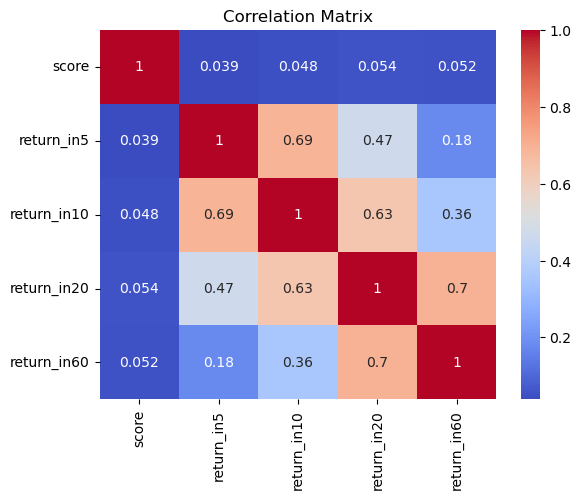

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

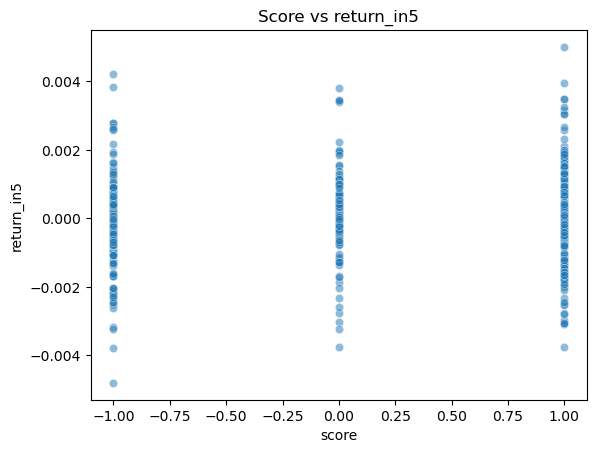

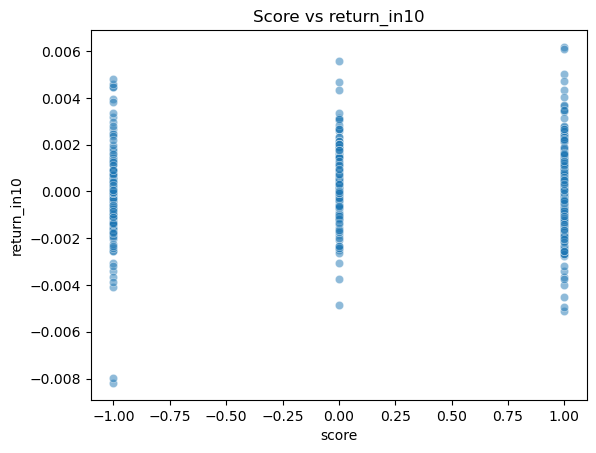

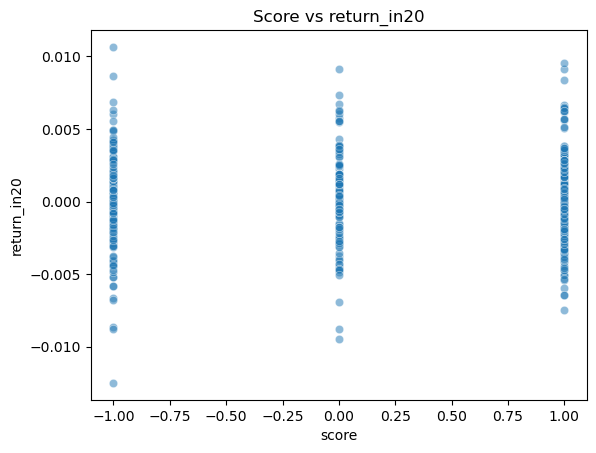

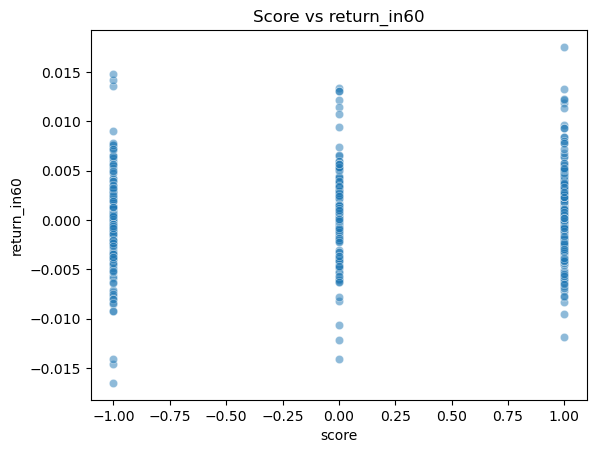

In [129]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=result_df, alpha=0.5)
    plt.title(f'Score vs {return_col}')
    plt.show()

In [130]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(498, 4)

In [131]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [132]:
lr.coef_

array([[6.00155687e-05],
       [1.01866435e-04],
       [1.94508183e-04],
       [2.83169310e-04]])

In [133]:
return_names = ["return_in5", "return_in10","return_in20","return_in60"]
for name in return_names:
    for j in [-1, 0, 1]:
        print(f"When score is {j}, the mean {name} is {result_df[result_df['score'] == j][name].mean()*10000}")
    

When score is -1, the mean return_in5 is -1.2381876033313075
When score is 0, the mean return_in5 is 0.8626983521536479
When score is 1, the mean return_in5 is 0.10146366707681977
When score is -1, the mean return_in10 is -1.4224555071923315
When score is 0, the mean return_in10 is 2.9507915025047575
When score is 1, the mean return_in10 is 0.9263396937641126
When score is -1, the mean return_in20 is 0.15848871677131568
When score is 0, the mean return_in20 is 2.3404339139433996
When score is 1, the mean return_in20 is 4.070644683261249
When score is -1, the mean return_in60 is -0.9109733518290943
When score is 0, the mean return_in60 is 5.882024854391691
When score is 1, the mean return_in60 is 5.120212348219088
